## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Read in dataset
df = pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# Number of rows: 294478
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [4]:
# Number of unique users: 290584
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
# Proportion of users converted: 0.12104
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# Number of times new_page and treatment don't line up: 3893
# This was found by querying the dataframe for all rows where we found combinations of new_page & control or old_page & treatment
df.query('landing_page == "new_page"').query('group == "control"').count() + df.query('landing_page == "old_page"').query('group == "treatment"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
# No rows have missing values
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Create df2 where all unaligned rows (treatment + old_page or control + new_page) have been removed
# Do this by querying df to create 2 dataframes a & b each with correct landing_page+ group alignment and then merging them 
a=df.query('landing_page == "new_page"').query('group == "treatment"')
b=df.query('landing_page == "old_page"').query('group == "control"')
df2=pd.merge(a,b,how='outer')
df2.head(3)

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
# df2 has 290584 unique users
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# The repated user is user_id: 773192
df2.groupby('user_id').count().sort_values(by='group', ascending=False).head(1)

,timestamp,group,landing_page,converted
user_id,,,,
773192,2,2,2,2


c. What is the row information for the repeat **user_id**? 

In [12]:
# Get row information for user_id: 773192
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# Remove 1 of 2 rows where user_id: 773192 and check to see it occurred
df2.drop_duplicates(subset='user_id',inplace=True)
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
# Conversion rate independent of page: 0.1196
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
# Conversion rate for control group: 0.1204
p_control = df2.query('group=="control"').converted.mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
# Conversion rate for treatment group: 0.1188
p_treatment = df2.query('group=="treatment"').converted.mean()
p_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
# Probability of receiving the new_page: 0.50006
df2.query('landing_page == "new_page"')['landing_page'].count()/df2['landing_page'].count()

0.50006194422266881

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

It appears that the new treatment page converts a bit worse than the old control page. 

Based on a sample of 290584 users the conversion rate on the control page is 0.1204 and the conversion rate on the treatment page is 0.1188. 

There is not evidence to suggest that the new treatment page converts better.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null Hypothesis (Ho):    **$p_{new}$** <= **$p_{old}$**

Alternative Hypothesis (Ha):    **$p_{new}$** > **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
# Becasue we assume under the null that p_new = p_old = p_converted
# We get p_new = 0.1196
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
# Becasue we assume under the null that p_new = p_old = p_converted
# We get p_old = 0.1196
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
# Number of trials for new_page: 145310
n_new = df2.query('landing_page == "new_page"')['user_id'].count()
n_new

145310

d. What is $n_{old}$?

In [21]:
# Number of trials for old_page: 145274
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# Use numpy random.binomial to simulate n_new trials and store in new_page_converted
new_page_converted = np.random.binomial(1, p_new,n_new)
new_page_converted.mean()

0.12034271557360127

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# Use numpy random.binomial to simulate n_old trials and store in old_page_converted
old_page_converted = np.random.binomial(1, p_old,n_old)
old_page_converted.mean()

0.12002836020210086

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
# p_new-p_old for the simulated values will be very close to 0.
new_page_converted.mean() - old_page_converted.mean()

0.00031435537150040216

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
# Create a sampling distribution of the simulated difference in proportions (p_new-p_old) stored in p_diffs
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new,n_new)
    old_page_converted = np.random.binomial(1, p_old,n_old)
    single_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(single_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   16.,   156.,   590.,  1722.,  2857.,  2587.,  1514.,   460.,
           84.,    14.]),
 array([ -4.39346702e-03,  -3.50214491e-03,  -2.61082280e-03,
         -1.71950069e-03,  -8.28178582e-04,   6.31435264e-05,
          9.54465635e-04,   1.84578774e-03,   2.73710985e-03,
          3.62843196e-03,   4.51975407e-03]),
 <a list of 10 Patch objects>)

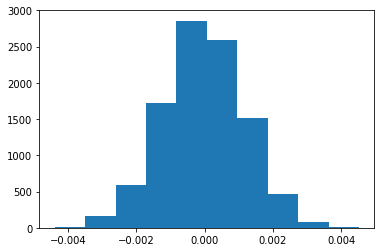

In [26]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

# Plot sampling distribution of the simulated difference in means 
# As we would expect from the central limit theorem centered at 0 and normally distributed
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

0.90510000000000002

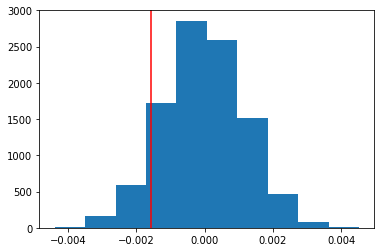

In [27]:
# Get actual difference
actual_diff = p_treatment-p_control

# Plot p_diffs again with actual difference shown
plt.hist(p_diffs)
plt.axvline(x=actual_diff, color='red')

# Compute percentage of p_diffs greater than actual difference in ab_data.csv
# The percentage of p_diffs greater than the actual difference is 90.4%
(p_diffs>actual_diff).mean()

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

We plotted a sampling distribution of the simulated difference between new page conversions and old page conversions. This sampling distribution is based on the assumption that the real proportion of conversions for both the new page and old page are equal.

By plotting this sampling distribution vs the actual observed difference we can see the percentage of the sampling distribution that is greater than our actual observed difference.

90.4% of our sampling distribution is greater than our actual observed statistic. 

Practically speaking: This tells us not only that our new page does not convert significantly better than our old page. It tells us that our old page is very likely better than our new page.

In scientific studies we called this value the p-value. With a  p-value of 0.904 we definitely fail to reject the null. That is, we do not have statistic evidence to say that the new page converts better than the old page. The p-value we would need to reject the null needs to be less than our previously stated alpha value of 0.05.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
# Import statsmodels.api package
import statsmodels.api as sm

# Set up variables to compute z-score and p-value
convert_old = df2.query('group=="control"').query('converted == 1')['user_id'].count()
convert_new = df2.query('group=="treatment"').query('converted == 1')['user_id'].count()
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

c:\users\pc\appdata\local\programs\python\python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
# Find z-score and p-value using statsmodels.api built in function
# define alternative='larger' as our alternative hypothesis is one directional and only cares if new_page is better than old_page
# z-score: -1.31, p-value: 0.905
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score and p-value mean that we fail to reject the null. The p-value we need to reject the null must be less than our stated alpha of 0.05. We have a p-value of 0.905. This in fact tells us that it is likely the old page converts better than the new page. We definitely cannot say we have statistical evidence to reject the null.

These values agree perfectly with our findings in part j and k.

Practically speaking: It still looks like we should stick with our old page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since we have a two option (conversion/no conversion) outcome to evaluate we should be perform a logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
# Create intercept and dummy variable column for page viewed
df3 = df2.join(pd.get_dummies(df2['group']))
df3.rename(columns={"treatment":"ab_page"}, inplace=True)
df3['intercept']=1
df3.head(1)

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
# Initiate and fit the model
logit_mod = sm.Logit(df3['converted'], df3[['intercept','ab_page']])
results=logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
# This is a workaround on an error discussed on github here: https://github.com/statsmodels/statsmodels/issues/3931
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# Show results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 Jan 2018   Pseudo R-squ.:               8.077e-06
Time:                        09:27:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value for ab_page is 0.19. This makes sense when you think about the null and alternative hypothesis associated with the regression model. 

For the regression model:

Null Hypothesis (Ho):    **$p_{new}$** = **$p_{old}$**

Alternative Hypothesis (Ha):    **$p_{new}$** != **$p_{old}$**


Where as from part 2:

Null Hypothesis (Ho):    **$p_{new}$** <= **$p_{old}$**

Alternative Hypothesis (Ha):    **$p_{new}$** > **$p_{old}$**

Therefore the regression model is doing a 2 sided z-test to check for a significant difference between **$p_{new}$** and **$p_{old}$** in either direction.

The p-value found in the regression model is equal to **$2*(1-pvalue)$** found in part 2.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is a good idea to consider other factors in your regression model. Although, we've determined overall that the new page doesn't convert better than the old page. If we can break up our sample into smaller groups we may find that within certain sub-samples that the new page performs significantly better. If that were the case, and if it makes economic/practical sense we may consider to implement the new page for those sub-populations going forward.

We will want to evaluate multiple factors both individually as well together. However, when evaluating various factors together in a regression model we need to be aware of the effects that multicollinearity might have on our interpretation.

When evaluating mulitple factors or testing for significance in various ways we need to be aware that we are more likely to find a significant p-value. To compensate for this the more tests we do the lower our alpha value will have to be for significance.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [33]:
# Read in countries dataframe and join it with our previous dataframe
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')

In [34]:
### Create the necessary dummy variables
df_new = df_new.join(pd.get_dummies(df_new['country']))

In [35]:
df_new.head(3)

,country,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0


In [36]:
# Initiate, fit and summarize the model
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','US','UK']])
results=logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 12 Jan 2018   Pseudo R-squ.:               1.521e-05
Time:                        09:27:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

It appears that country did have an impact on conversation. We can say with a p-value = 0.129 and a coef of 0.0408 that conversion for Canada based participants was worse than for US based participants. We can also say that with a p-value = 0.074 and coef of 0.0507 that conversion for Canada based participants was worse than for UK based participants.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [37]:
### Fit Your Linear Model And Obtain the Results considering both country and page
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','US','UK','ab_page']])
results=logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 12 Jan 2018   Pseudo R-squ.:               2.323e-05
Time:                        09:27:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""



Z-values, p-values and coefficients are essentially unchanged from the previous 2 regressions. Therefore it appears that page and country don't have any interaction with a significant effect to conversion.

<a id='conclusions'></a>
## Conclusions

As stated in the Introduction. The goal of this analysis was to help the company understand the results of their A/B test and if they should implement the new page or keep the old page.

We started with a Null Hypothesis (Ho):

**$p_{new}$** <= **$p_{old}$**

If we could show with a statistical significance of p-value less than alpha = 0.05 we would reject the Null in favor of our Alternative Hypothesis (Ha):    

**$p_{new}$** > **$p_{old}$**

Assuming it made practical sense to do so that would mean we'd recommend to the company to switch to the new page.

Otherwise, we'd recommend they stayed with the old page.

We took the entire collected dataset and analyzed it in 3 different ways.
- We used bootstrapping to simulate a distribution of sampled mean differences (new_page - old_page) under the null then compared this distribution to our observed actual difference in conversions from the dataset.
- We used a Z-test to see if the new page performed significantly better than the old_page
- We used logistic regression to see if conversion improved from the old_page to the new_page and also how conversion differed across countries.

In all 3 of our analysis we found that the new_page is not significantly better than the old_page. We found that it is in fact likely a little bit worse.

In scientific terms we fail to reject our null hypothesis: Null Hypothesis (Ho):    **$p_{new}$** <= **$p_{old}$** based on alpha of 0.05.

In practical terms our recommendation is to stay with the old_page.


## Resources used during project
- https://stackoverflow.com/
- Udacity - Data Analyst Nanodegree lectures
- Slack - Udacity Data Science Group
- https://github.com/statsmodels/statsmodels/issues/3931

## Bonus Exploration

### Part 4: Exploring the Time Component

In this section I look at how the p-value and effect size change as each day of the experiment passes.

In [134]:
# Create dataframe to be used for analysis over time
df_t = df_new
df_t['timestamp'] = pd.to_datetime(df_t['timestamp'])
df_t.head(3)

,country,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US,day
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,13
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1,22
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0,15


In [136]:
# Look at start and end of experiment to understand frequency and duration of experiment
# Experiment runs over 23 days with clicks every couple of seconds
df_t.sort_values(by='timestamp').head(2)

,country,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US,day
user_id,,,,,,,,,,,,
922696,US,2017-01-02 13:42:05.378582,treatment,new_page,0,0,1,1,0,0,1,1
781507,UK,2017-01-02 13:42:15.234051,control,old_page,0,1,0,1,0,1,0,1


In [137]:
df_t.sort_values(by='timestamp',ascending=False).head(2)

,country,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US,day
user_id,,,,,,,,,,,,
920411,CA,2017-01-24 13:41:54.460509,control,old_page,0,1,0,1,1,0,0,23
836373,US,2017-01-24 13:41:52.604673,control,old_page,0,1,0,1,0,0,1,23


In [138]:
# Create column to represent day of experiment not day of month
df_t['day'] = df_t['timestamp'].dt.day
df_t['day'] = df_t['day']-1

In [139]:
# Use a for loop to get p-value and treatment effects updated on a daily basis for the full 23 days of the experiment
p_values=[]
treatment_effects=[]
days=[]
i=1
for _ in range(23):
    convert_old = df_t.query('group=="control"').query('converted == 1').query('day <= @i')['day'].count()
    convert_new = df_t.query('group=="treatment"').query('converted == 1').query('day <= @i')['day'].count()
    n_old = df_t.query('landing_page == "old_page"').query('day <= @i')['day'].count()
    n_new = df_t.query('landing_page == "new_page"').query('day <= @i')['day'].count()
    z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
    treatment_effect =(convert_new/n_new - convert_old/n_old)/(convert_old/n_old)

    p_values.append(p_value)
    treatment_effects.append(treatment_effect)
    days.append(i)
    i+=1
    
p_value, convert_old, convert_new, n_old, n_new, i

(0.90505831275902449, 17489, 17264, 145274, 145310, 24)

In [140]:
# Convert to numpy arrays
p_values = np.array(p_values)
treatment_effects = np.array(treatment_effects)
days = np.array(days)

([<matplotlib.axis.XTick at 0x22102442a58>,
 <a list of 12 Text xticklabel objects>)

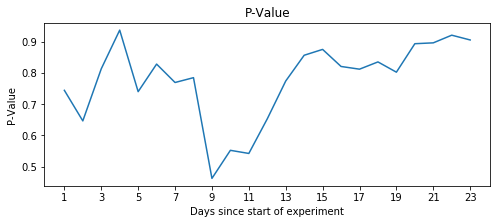

In [141]:
# Plotting p-value over time of experiment
plt.subplots(figsize=(8, 3))
plt.plot(days,p_values)
plt.title('P-Value')
plt.xlabel('Days since start of experiment')
plt.ylabel('P-Value')
plt.xticks(np.arange(1, 25, 2))

([<matplotlib.axis.XTick at 0x22102b4bfd0>,
 <a list of 12 Text xticklabel objects>)

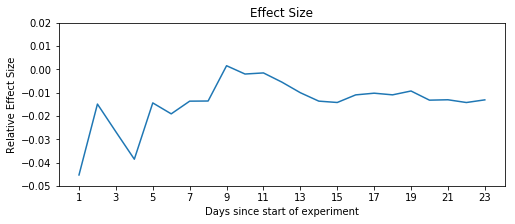

In [142]:
# Plotting effect size over time of experiment
plt.subplots(figsize=(8, 3))
plt.plot(days,treatment_effects)
plt.title('Effect Size')
plt.xlabel('Days since start of experiment')
plt.ylabel('Relative Effect Size')
plt.yticks(np.arange(-0.05, 0.02,0.01))
plt.xticks(np.arange(1, 25, 2))

### Conclusions based on time data

Based on the time data it looks as if the p-value and effect size both seem to normalize at about the 14 to 15 days mark.
If I were running this experiment I would likely be able to stop it by day 16 and conclude that the new page was slightly less effective than the old page.

### Future potential areas to explore
A/B tests are an extremely interesting topic. After this project I plan to research more on the details of A/B testing and perhaps get more experience by A/B testing various features of my blog to try and optimize email signups.


### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.